# Tracking and Predictions

## Load Predictions

In [6]:
import os
import numpy as np
from collections import defaultdict
from tqdm import tqdm
import os
import h5py

config

In [7]:
# Configuration
sequence_name = "thun_01_b"
split = "test"
num_frames = 1617

idx = 99
SCALE_Y = 360 / 480  # = 0.75

In [8]:
# Load GT
gt_pred_path = os.path.join("data/dsec_proc",split,sequence_name,"labels_v2","labels.npz")
# Load RGB Predictions
rgb_pred_path = os.path.join("rgb_pred",f"{sequence_name}.npy")
# Load Event predictions
event_pred_path = os.path.join("predictions",f"{sequence_name}.npz")

Load GT

In [9]:
gt_file = np.load(gt_pred_path, allow_pickle = True)

Load RGB predictions

In [10]:
# Load RGB predictions
rgb_pred_file = np.load(rgb_pred_path, allow_pickle=True)

rgb_preds_by_frame = defaultdict(list)

for item in rgb_pred_file:
    x1,y1,x2,y2 = item['bbox']

    frame_idx = item['frame_idx']
    confidence = item['confidence']
    rgb_preds_by_frame[item['frame_idx']]

    if item['class_id'] == 3:
        class_id = 2

    elif item['class_id'] == 1:
        class_id = 0

    else:
        continue

    rgb_preds_by_frame[frame_idx].append([x1, y1, x2, y2, confidence, class_id])


Load Event predictions

In [11]:
event_pred_file = np.load(event_pred_path, allow_pickle=True)

## Data managment

Get the detections in the same format so I can work easily with gt rgb and events detections

### Events

In [12]:
def convert_predictions(predictions_file,num_frames):
    """
    Convert (frame_id, class_id, [x, y, w, h], confidence) predictions
    to {frame_id: [[x1, y1, x2, y2, confidence, class_id], ...]}
    """
    preds_by_frame = defaultdict(list)

    for pred in predictions_file['predictions']:
        
        x1,y1,x2,y2 = pred['bbox']

        # Define the original and new resolution
        original_resolution = 360
        new_resolution = 480

        # Calculate the scale factor
        scale_factor = new_resolution / original_resolution

        # Apply the scale factor to the coordinates
        y1_new =  y1 * scale_factor
        y2_new =  y2 * scale_factor

        frame_idx = pred['frame_idx']
        confidence = pred['confidence']
        class_id = pred['class_id']

        preds_by_frame[frame_idx].append([x1, y1_new, x2, y2_new, confidence, class_id])

    return preds_by_frame

In [13]:
def convert_gt(gt_file, num_frames):
    obj_2_idx_array = gt_file['objframe_idx_2_label_idx']
    gt_by_frame = defaultdict(list)

    count = 0
    for idx in obj_2_idx_array:

        label = gt_file['labels'][count]
        count = count + 1

        original_resolution = 360
        new_resolution = 480

        # Calculate the scale factor
        scale_factor = new_resolution / original_resolution

        x, y, w, h = label['x'], label['y'], label['w'], label['h']
        x1 = x
        y1 = y 
        x2 = x + w
        y2 = y1 + h

        y1_new =  y1 * scale_factor
        y2_new =  y2 * scale_factor

        confidence = label['class_confidence']
        class_id = label['class_id']
        track_id = label['track_id']

        gt_by_frame[idx].append([x1, y1_new, x2, y2_new, confidence, class_id,track_id])

    return gt_by_frame


In [14]:
# 1. Initialize the metric
#metric_fn = MetricBuilder.build_evaluation_metric("map_2d", async_mode=True,num_classes=2)
gt_by_frame = convert_gt(gt_file,num_frames)
event_preds_by_frame = convert_predictions(event_pred_file,num_frames)

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def draw_bboxes_on_image(gt_boxes, pred_boxes, idx, image_size=(480, 640), confidence=0.5,sequence_name="0"):
    height, width = image_size
    image = cv2.imread(f"{sequence_name}/0000{idx}.png")
    if image is None:
        raise ValueError(f"Image  could not be loaded.")

    # Draw GT boxes in green
    for box in gt_boxes:
        x1, y1, x2, y2, _, cls,track_id = map(int, box)
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(image, f"GT:{cls}", (x1, y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Draw predicted boxes in red
    for box in pred_boxes:
        x1, y1, x2, y2, conf, cls = box
        x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
        
        if conf > confidence:
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 255), 2)
            cv2.putText(image, f"P:{int(cls)} {conf:.2f}", (x1, y2 + 15),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

    # Show the image
    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("Green = Ground Truth, Red = Prediction")
    plt.show()


### RGB

[[426.0, 208.0, 548.0, 297.3333333333333, 0.9999496, 2, 89], [208.0, 212.0, 288.0, 268.0, 0.99983263, 2, 84], [324.0, 209.33333333333331, 343.0, 222.66666666666666, 0.99976736, 2, 83], [369.0, 206.66666666666666, 397.0, 230.66666666666666, 0.9996705, 2, 81], [504.0, 205.33333333333331, 680.0, 449.3333333333333, 0.9986339, 2, 80], [-5.0, 212.0, 188.0, 445.3333333333333, 0.9981036, 2, 85], [340.0, 206.66666666666666, 353.0, 218.66666666666666, 0.8791999, 2, 93]]


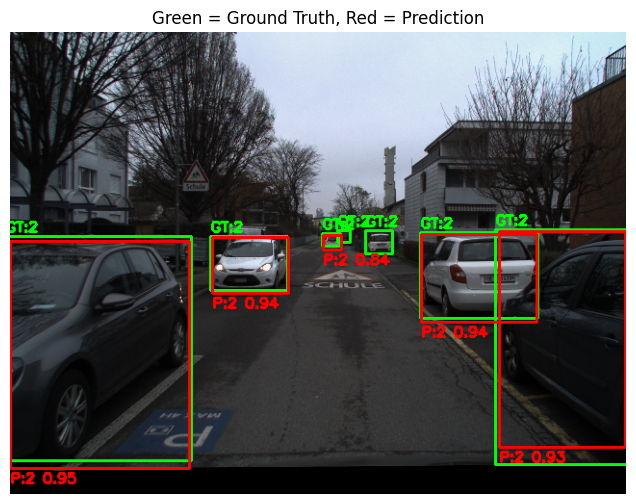

In [16]:
frame_id = idx
gt_boxes = gt_by_frame[frame_id]

print(gt_boxes)
pred_boxes = rgb_preds_by_frame[frame_id]
draw_bboxes_on_image(gt_boxes, pred_boxes,frame_id,confidence=.75,sequence_name=sequence_name)


### EVENT

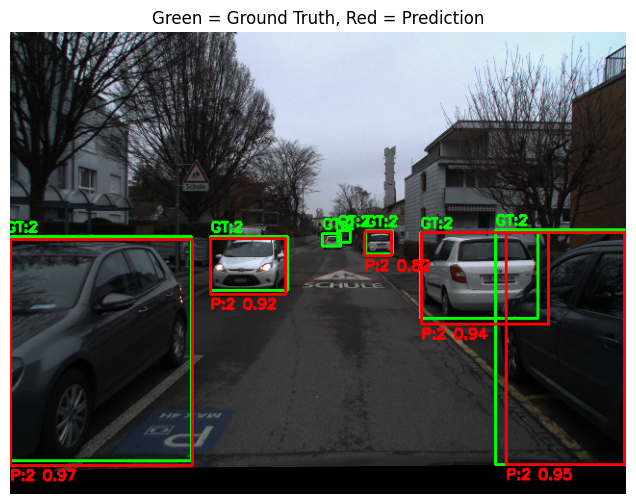

In [17]:
gt_boxes = gt_by_frame[frame_id]
pred_boxes = event_preds_by_frame[frame_id]
draw_bboxes_on_image(gt_boxes, pred_boxes,idx=frame_id,confidence=.8,sequence_name=sequence_name)

In [18]:
print(len(gt_by_frame))

1079


In [19]:
print(f"lenght of gt_by_frame: {len(gt_by_frame)}")
print(f"lenght of rgb_by_frame: {len(rgb_preds_by_frame)}")
print(f"lenght of event_preds_by_frame: {len(event_preds_by_frame)}")


lenght of gt_by_frame: 1079
lenght of rgb_by_frame: 1079
lenght of event_preds_by_frame: 1078


### NMS for Events

In [94]:
import numpy as np
import torchvision.ops as ops  # for NMS
import torch

def apply_nms_to_frame(predictions, iou_threshold=0.5):
    boxes = []
    scores = []
    class_ids = []
    
    for box in predictions:
        boxes.append(box[:4])
        scores.append(box[4])
        class_ids.append(int(box[5]))  # Ensure class ID is integer
    
    boxes = torch.tensor(boxes, dtype=torch.float32)
    scores = torch.tensor(scores, dtype=torch.float32)
    class_ids = np.array(class_ids)

    # Perform NMS per class
    final_indices = []
    for cls in np.unique(class_ids):
        cls_mask = (class_ids == cls)
        cls_boxes = boxes[cls_mask]
        cls_scores = scores[cls_mask]
        
        if cls_boxes.shape[0] == 0:
            continue
        
        keep = ops.nms(cls_boxes, cls_scores, iou_threshold)
        cls_indices = np.where(cls_mask)[0][keep.numpy()]
        final_indices.extend(cls_indices)

    return [predictions[i] for i in final_indices]

nms_events_by_frame = {}
for frame_id, preds in event_preds_by_frame.items():
    nms_events_by_frame[frame_id] = apply_nms_to_frame(preds)


Filter Detetctions by confidence

In [95]:
#RGB_CONFIDENCE_THRESHOLD = 0.5
#EVENT__CONFIDENCE_THRESHOLD = 0.85

RGB_CONFIDENCE_THRESHOLD = 0.0

rgb_filtered = {
    frame: [det for det in dets if det[4] >= RGB_CONFIDENCE_THRESHOLD]
    
    for frame, dets in rgb_preds_by_frame.items()
}

## Metrics

In [20]:
gt_bboxes = {}
rgb_bboxes = {}
event_bboxes = {}

for idx in gt_by_frame:
    gt_bboxes[idx] = gt_by_frame[idx]


for idx in rgb_preds_by_frame:
    rgb_bboxes[idx] = rgb_preds_by_frame[idx]


for idx in event_preds_by_frame:
    event_bboxes[idx] = event_preds_by_frame[idx]

## How To convert them to arrays for detection metrics


In [21]:
print(gt_bboxes)


{0: [[281.0, 184.0, 543.0, 324.0, 0.9981804, 2, 77], [-5.0, 217.33333333333331, 24.0, 248.0, 0.9921657, 2, 80]], 1: [[-3.0, 217.33333333333331, 41.0, 249.33333333333331, 0.9993717, 2, 80], [291.0, 184.0, 569.0, 329.3333333333333, 0.9981489, 2, 77]], 2: [[12.0, 217.33333333333331, 56.0, 249.33333333333331, 0.9992675, 2, 80], [310.0, 181.33333333333331, 593.0, 330.66666666666663, 0.99784863, 2, 77], [-2.0, 217.33333333333331, 18.0, 233.33333333333331, 0.9966306, 2, 81], [10.0, 220.0, 23.0, 242.66666666666666, 0.8824019, 2, 82]], 3: [[-5.0, 220.0, 15.0, 242.66666666666666, 0.9996419, 2, 83], [29.0, 217.33333333333331, 72.0, 249.33333333333331, 0.9994486, 2, 80], [325.0, 177.33333333333331, 616.0, 336.0, 0.9969688, 2, 77], [16.0, 217.33333333333331, 35.0, 233.33333333333331, 0.99575007, 2, 81], [28.0, 220.0, 41.0, 242.66666666666666, 0.7303218, 2, 82]], 4: [[-3.0, 220.0, 33.0, 244.0, 0.9997867, 2, 83], [46.0, 217.33333333333331, 87.0, 248.0, 0.99918, 2, 80], [338.0, 177.33333333333331, 656

In [23]:
RGB_CONFIDENCE_THRESHOLD = 0.75
EVENT__CONFIDENCE_THRESHOLD = 0.0


rgb_filtered = {
frame: [det for det in dets if det[4] >= RGB_CONFIDENCE_THRESHOLD]

for frame, dets in rgb_preds_by_frame.items()
}

event_filtered = {
frame: [det for det in dets if det[4] >= EVENT__CONFIDENCE_THRESHOLD]
for frame, dets in event_preds_by_frame.items()
}

In [26]:
from mean_average_precision import MetricBuilder
import numpy as np

# Your original classes
original_classes = [0, 2]
class_id_map = {orig: idx for idx, orig in enumerate(sorted(original_classes))}
print(f"[INFO] Class ID mapping: {class_id_map}")

# Initialize metric
num_classes = len(original_classes)
metric_fn = MetricBuilder.build_evaluation_metric("map_2d", async_mode=True, num_classes=num_classes)

# Loop over frames
for frame_id in gt_bboxes.keys():
    gt_raw = gt_bboxes.get(frame_id, [])
    pred_raw = event_filtered.get(frame_id, [])

    # Convert GT

    gt = np.array([
        [x[0], x[1], x[2], x[3], class_id_map[int(x[5])], 0, 0]  # class_id is at index 5
        for x in gt_raw if int(x[5]) in class_id_map
    ], dtype=np.float32)

    # Convert Predictions
    preds = np.array([
        [x[0], x[1], x[2], x[3], class_id_map[int(x[5])], x[4]]  # class_id is at index 5, confidence is at index 4
        for x in pred_raw if int(x[5]) in class_id_map
    ], dtype=np.float32)


    metric_fn.add(preds, gt)

# Compute and print final metrics
metrics = metric_fn.value(iou_thresholds=[0.5, 0.75])

print("\n[RESULT] Final metric keys:", metrics.keys())
if "mAP" in metrics:
    print("[RESULT] Average mAP:", metrics["mAP"])
else:
    print("[ERROR] 'mAP' not found in metrics result!")




[INFO] Class ID mapping: {0: 0, 2: 1}

[RESULT] Final metric keys: dict_keys([0.5, 0.75, 'mAP'])
[RESULT] Average mAP: 0.039855164


In [28]:
def get_metrics(preds_filtered, gt_bboxes, original_classes = [0, 2],iou_thresholds=[0.5, 0.75]):

    class_id_map = {orig: idx for idx, orig in enumerate(sorted(original_classes))}

    # Initialize metric
    num_classes = len(original_classes)
    metric_fn = MetricBuilder.build_evaluation_metric("map_2d", async_mode=True, num_classes=num_classes)

    # Loop over frames
    for frame_id in gt_bboxes.keys():
        gt_raw = gt_bboxes.get(frame_id, [])
        pred_raw = preds_filtered.get(frame_id, [])

        # Convert GT

        gt = np.array([
            [x[0], x[1], x[2], x[3], class_id_map[int(x[5])], 0, 0]  # class_id is at index 5
            for x in gt_raw if int(x[5]) in class_id_map
        ], dtype=np.float32)

        # Convert Predictions
        preds = np.array([
            [x[0], x[1], x[2], x[3], class_id_map[int(x[5])], x[4]]  # class_id is at index 5, confidence is at index 4
            for x in pred_raw if int(x[5]) in class_id_map
        ], dtype=np.float32)


        metric_fn.add(preds, gt)

    # Compute and print final metrics
    metrics = metric_fn.value(iou_thresholds)

    return metrics

    

In [29]:
print(results.keys())

NameError: name 'results' is not defined

In [31]:
print("-------------0.5 aMP---------------")

print()
results = metrics[0.5]


print(results[1]['precision'][-1])

print(f"class 0 mAP: {np.average(results[0]['ap'])}")
print(f"class 0 precision: {np.average(results[0]['precision'])}")
print(f"class 0 recall: {np.average(results[0]['recall'])}")

print(f"class 1 precision: {np.average(results[1]['precision'])}")
print(f"class 1 recall: {np.average(results[1]['recall'])}")

print("-------------0.75 aMP---------------")

results = metrics[0.75]
print(results[1]['precision'][:100])

print(f"class 0 precision: {np.average(results[0]['precision'])}")
print(f"class 0 recall: {np.average(results[0]['recall'])}")

print(f"class 1 precision: {np.average(results[1]['precision'])}")
print(f"class 1 recall: {np.average(results[1]['recall'])}")

-------------0.5 aMP---------------

0.005675651483110111
class 0 mAP: 0.1006259173154831
class 0 precision: 0.007189016939515777
class 0 recall: 0.5186935974161679
class 1 precision: 0.017186764266247566
class 1 recall: 0.579348623790248
-------------0.75 aMP---------------
[1.         0.5        0.33333333 0.25       0.2        0.16666667
 0.14285714 0.125      0.11111111 0.1        0.09090909 0.08333333
 0.07692308 0.07142857 0.06666667 0.0625     0.05882353 0.05555556
 0.05263158 0.05       0.0952381  0.09090909 0.08695652 0.08333333
 0.08       0.07692308 0.07407407 0.07142857 0.06896552 0.06666667
 0.06451613 0.0625     0.06060606 0.05882353 0.05714286 0.05555556
 0.05405405 0.05263158 0.05128205 0.05       0.04878049 0.07142857
 0.06976744 0.06818182 0.06666667 0.06521739 0.06382979 0.0625
 0.06122449 0.06       0.05882353 0.05769231 0.05660377 0.05555556
 0.05454545 0.05357143 0.05263158 0.05172414 0.05084746 0.05
 0.04918033 0.0483871  0.06349206 0.0625     0.06153846 0.060606

In [ ]:
from collections import defaultdict
from tqdm import tqdm
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

def evaluate_precision_recall(gt_list, pred_list, iou_thresh=0.5):
    """
    gt_list: dict of frame_idx -> list of arrays [x1, y1, x2, y2, conf, class] (GT conf is ignored)
    pred_list: dict of frame_idx -> list of arrays [x1, y1, x2, y2, conf, class]
    iou_thresh: IoU threshold to consider a prediction a TP
    """
    def compute_iou(boxA, boxB):
        xA = max(boxA[0], boxB[0])
        yA = max(boxA[1], boxB[1])
        xB = min(boxA[2], boxB[2])
        yB = min(boxA[3], boxB[3])
        interArea = max(0, xB - xA) * max(0, yB - yA)
        boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
        boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
        iou = interArea / float(boxAArea + boxBArea - interArea + 1e-6)
        return iou

    gt = defaultdict(list)
    preds_by_class = defaultdict(list)

    # Step 1: Aggregate all boxes across frames by class
    for frame_idx in gt_list:
        if frame_idx not in pred_list:
            continue

        gt_bboxes_per_frame = gt_list[frame_idx]
        pred_bboxes_per_frame = pred_list[frame_idx]

        for g in gt_bboxes_per_frame:
            box = g[:4]
            cls = int(g[5])
            gt[cls].append(box)

        for p in pred_bboxes_per_frame:
            box = p[:4]
            conf = p[4]
            cls = int(p[5])
            preds_by_class[cls].append((box, conf))

    results = {}
    all_classes = sorted(set(gt.keys()) | set(preds_by_class.keys()))

    # Step 2: Match predictions to GTs and compute PR per class
    for cls in all_classes:
        gt_boxes = gt.get(cls, [])
        preds = preds_by_class.get(cls, [])

        preds.sort(key=lambda x: x[1], reverse=True)

        y_true = []
        y_scores = []
        used_gt = set()

        for pred_box, conf in tqdm(preds, desc=f"Processing class {cls}"):
            best_iou = 0
            best_idx = -1

            for idx, gt_box in enumerate(gt_boxes):
                if idx in used_gt:
                    continue
                iou = compute_iou(pred_box, gt_box)
                if iou > best_iou:
                    best_iou = iou
                    best_idx = idx

            if best_iou >= iou_thresh:
                y_true.append(1)
                used_gt.add(best_idx)
            else:
                y_true.append(0)
            y_scores.append(conf)

        # Add false negatives
        num_fn = len(gt_boxes) - len(used_gt)
        if num_fn > 0:
            y_true.extend([1] * num_fn)
            y_scores.extend([0.0] * num_fn)

        if len(set(y_true)) < 2:
            print(f"Skipping class {cls} (not enough pos/neg examples)")
            continue

        precision, recall, _ = precision_recall_curve(y_true, y_scores)
        ap = average_precision_score(y_true, y_scores)

        results[cls] = {
            'precision': precision,
            'recall': recall,
            'ap': ap
        }

    # Step 3: Plot PR curves
    for cls, data in results.items():
        plt.plot(data['recall'], data['precision'], label=f'Class {cls} AP = {data["ap"]:.2f}')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curves by Class")
    plt.legend()
    plt.grid(True)
    plt.show()

    return results


RGB PC-RC

Processing class 2: 100%|██████████| 21121/21121 [02:03<00:00, 170.63it/s] 


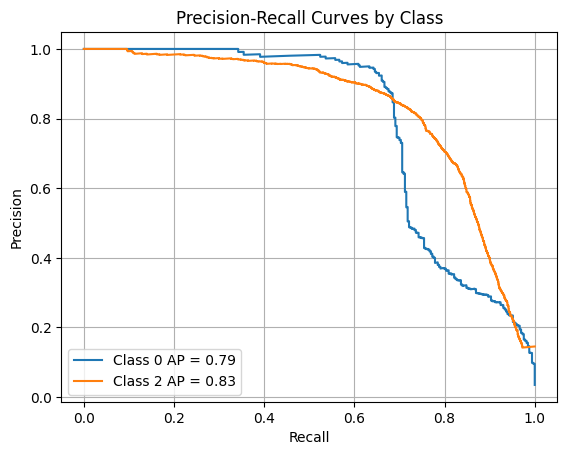

Class 0 AP = 0.786
Class 2 AP = 0.829


In [ ]:
results = evaluate_precision_recall(gt_bboxes, rgb_bboxes, iou_thresh=0.5)
for cls, metrics in results.items():
    print(f"Class {cls} AP = {metrics['ap']:.3f}")

In [ ]:
EVENT__CONFIDENCE_THRESHOLD = 0.9

event_filtered = {
    frame: [det for det in dets if det[4] >= EVENT__CONFIDENCE_THRESHOLD]
    for frame, dets in event_preds_by_frame.items()
}

EVENT PC-RC

Processing class 0: 0it [00:00, ?it/s]


Skipping class 0 (not enough pos/neg examples)


Processing class 1: 100%|██████████| 6/6 [00:00<00:00, 52758.54it/s]


Skipping class 1 (not enough pos/neg examples)


Processing class 2:   0%|          | 0/9208 [00:00<?, ?it/s]

Processing class 2: 100%|██████████| 9208/9208 [03:00<00:00, 51.09it/s]


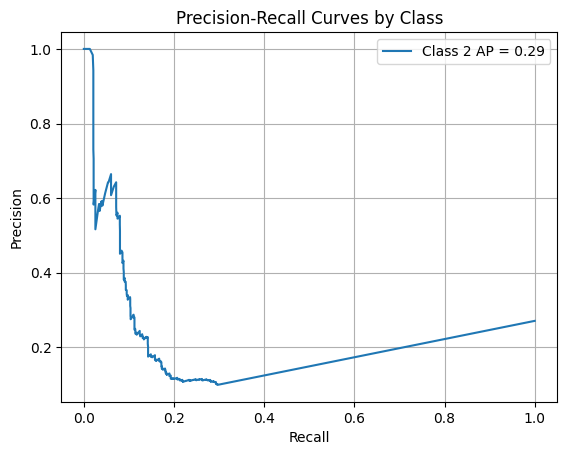

Class 2 AP = 0.286


In [ ]:
results = evaluate_precision_recall(gt_bboxes, event_filtered, iou_thresh=0.5)
for cls, metrics in results.items():
    print(f"Class {cls} AP = {metrics['ap']:.3f}")

## Detection Merging and Tracking

Get event representation img

In [ ]:
def get_event_frame_rgb(index, frame_img, sequence_name, downsample=True,split='test',alpha=0.5):
    h5_path = os.path.join('data/dsec_proc',split,sequence_name,"event_representations_v2/stacked_histogram_dt=50_nbins=10/event_representations_ds2_nearest.h5")
    with h5py.File(h5_path, 'r') as f:
        data = f['/data']  # Shape: (N, 2*T, H, W)

        if index >= data.shape[0]:
            #raise IndexError(f"Index {index} out of bounds for dataset with {data.shape[0]} frames.")
            index = index -1

        frame = data[index]  # Shape: (2*T, H, W)
        T = frame.shape[0] // 2
        pos = np.sum(frame[:T], axis=0)
        neg = np.sum(frame[T:], axis=0)

        if downsample:
            target_size = (frame_img.shape[1], frame_img.shape[0])
            pos = cv2.resize(pos, target_size, interpolation=cv2.INTER_NEAREST)
            neg = cv2.resize(neg, target_size, interpolation=cv2.INTER_NEAREST)

        # Normalize to 0–255
        pos_norm = cv2.normalize(pos, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        neg_norm = cv2.normalize(neg, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

        # Create RGB event image: Red = positive, Blue = negative
        event_rgb = np.zeros_like(frame_img, dtype=np.uint8)
        event_rgb[..., 2] = pos_norm  # Red
        event_rgb[..., 0] = neg_norm  # Blue

        # Blend events onto the frame
        blended = cv2.addWeighted(frame_img, 1.0, event_rgb, alpha, 0)

        return blended

## Merge Detections

### Weighted Boxes Fusion

In [ ]:
from ensemble_boxes import weighted_boxes_fusion
from collections import defaultdict
import numpy as np

def convert_to_wbf_input(detections, image_width, image_height):
    boxes, scores, labels = [], [], []
    for det in detections:
        x1, y1, x2, y2, score, label = det
        boxes.append([x1 / image_width, y1 / image_height, x2 / image_width, y2 / image_height])
        scores.append(score)
        labels.append(int(label))
    return boxes, scores, labels

def mark_used_boxes(fused_boxes, orig_boxes, iou_thr):
    used = [False] * len(orig_boxes)
    for fbox in fused_boxes:
        for i, obox in enumerate(orig_boxes):
            # Calculate IoU
            ixmin = max(fbox[0], obox[0])
            iymin = max(fbox[1], obox[1])
            ixmax = min(fbox[2], obox[2])
            iymax = min(fbox[3], obox[3])
            iw = max(ixmax - ixmin, 0)
            ih = max(iymax - iymin, 0)
            inter = iw * ih
            area_f = (fbox[2] - fbox[0]) * (fbox[3] - fbox[1])
            area_o = (obox[2] - obox[0]) * (obox[3] - obox[1])
            union = area_f + area_o - inter
            iou = inter / union if union > 0 else 0
            if iou >= iou_thr:
                used[i] = True
                break
    return used

merged_by_frame = defaultdict(list)
IMAGE_WIDTH = 640
IMAGE_HEIGHT = 480
IOU_THR = 0.5
SKIP_THR = 0.0
WEIGHTS = [0.7, 0.3]

for frame_idx in tqdm(set(rgb_filtered.keys()).union(event_filtered.keys())):
    rgb_dets = rgb_filtered.get(frame_idx, [])
    event_dets = event_filtered.get(frame_idx, [])

    rgb_boxes, rgb_scores, rgb_labels = convert_to_wbf_input(rgb_dets, IMAGE_WIDTH, IMAGE_HEIGHT)
    event_boxes, event_scores, event_labels = convert_to_wbf_input(event_dets, IMAGE_WIDTH, IMAGE_HEIGHT)

    boxes_list = [rgb_boxes, event_boxes]
    scores_list = [rgb_scores, event_scores]
    labels_list = [rgb_labels, event_labels]

    fused_boxes, fused_scores, fused_labels = weighted_boxes_fusion(
        boxes_list, scores_list, labels_list,
        iou_thr=IOU_THR, skip_box_thr=SKIP_THR, weights=WEIGHTS
    )

    # Convert fused boxes back to absolute coords
    detections_fused = []
    for box, score, label in zip(fused_boxes, fused_scores, fused_labels):
        x1 = box[0] * IMAGE_WIDTH
        y1 = box[1] * IMAGE_HEIGHT
        x2 = box[2] * IMAGE_WIDTH
        y2 = box[3] * IMAGE_HEIGHT
        detections_fused.append([x1, y1, x2, y2, score, int(label)])

    # Mark used boxes from original detections
    all_orig_boxes = rgb_boxes + event_boxes
    all_orig_dets = rgb_dets + event_dets
    used_flags = mark_used_boxes(fused_boxes, all_orig_boxes, iou_thr=IOU_THR)

    # Add unmatched original boxes
    for used, det in zip(used_flags, all_orig_dets):
        if not used and det[4] >= SKIP_THR:
            detections_fused.append(det)

    merged_by_frame[frame_idx] = detections_fused



  0%|          | 0/1079 [00:00<?, ?it/s]/home/hsosapavon/.conda/envs/rvt/lib/python3.9/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:54: UserWarning: Y1 < 0 in box. Set it to 0.
  warnings.warn('Y1 < 0 in box. Set it to 0.')
/home/hsosapavon/.conda/envs/rvt/lib/python3.9/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:42: UserWarning: X1 < 0 in box. Set it to 0.
  warnings.warn('X1 < 0 in box. Set it to 0.')
  0%|          | 4/1079 [00:00<03:13,  5.56it/s]/home/hsosapavon/.conda/envs/rvt/lib/python3.9/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:51: UserWarning: X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')
  1%|          | 7/1079 [00:01<03:05,  5.78it/s]/home/hsosapavon/.conda/envs/rvt/lib/python3.9/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:63: UserWarning: Y2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warni

### NMS

In [ ]:
from collections import defaultdict
import numpy as np
import torch
from torchvision.ops import nms

def run_nms(detections, iou_threshold):
    """
    Apply NMS on a list of detections: [x1, y1, x2, y2, score, label]
    """
    if len(detections) == 0:
        return []

    boxes = torch.tensor([d[:4] for d in detections], dtype=torch.float32)
    scores = torch.tensor([d[4] for d in detections], dtype=torch.float32)
    labels = [int(d[5]) for d in detections]

    keep_indices = nms(boxes, scores, iou_threshold)
    return [detections[i] for i in keep_indices]

merged_by_frame = defaultdict(list)
IMAGE_WIDTH = 640
IMAGE_HEIGHT = 480
IOU_THR = 0.5
SKIP_THR = 0.0

for frame_idx in set(rgb_filtered.keys()).union(event_filtered.keys()):
    rgb_dets = rgb_filtered.get(frame_idx, [])
    event_dets = event_filtered.get(frame_idx, [])

    # Combine all detections from both sources
    all_dets = rgb_dets + event_dets

    # Filter out low-score boxes early
    all_dets = [d for d in all_dets if d[4] >= SKIP_THR]

    # Run NMS on all detections
    detections_fused = run_nms(all_dets, iou_threshold=IOU_THR)

    merged_by_frame[frame_idx] = detections_fused


### IoU + Confidence Fusion

In [ ]:
from collections import defaultdict
import numpy as np

def compute_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    areaA = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    areaB = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    union = areaA + areaB - interArea
    return interArea / union if union > 0 else 0.0

def fuse_detections_iou_conf(rgb_dets, event_dets, iou_threshold=0.5, conf_threshold=0.0):
    fused = []
    used_event = set()

    for rgb_box in rgb_dets:
        x1, y1, x2, y2, conf_rgb, cls_rgb = rgb_box
        best_iou = 0
        best_idx = -1

        for i, event_box in enumerate(event_dets):
            if i in used_event:
                continue
            x1_e, y1_e, x2_e, y2_e, conf_e, cls_e = event_box
            if cls_rgb != cls_e:
                continue

            iou_val = compute_iou([x1, y1, x2, y2], [x1_e, y1_e, x2_e, y2_e])
            if iou_val > best_iou:
                best_iou = iou_val
                best_idx = i

        if best_iou >= iou_threshold:
            # Fuse matched boxes
            matched_box = event_dets[best_idx]
            used_event.add(best_idx)

            x1_f = (x1 + matched_box[0]) / 2
            y1_f = (y1 + matched_box[1]) / 2
            x2_f = (x2 + matched_box[2]) / 2
            y2_f = (y2 + matched_box[3]) / 2
            conf_f = max(conf_rgb, matched_box[4])
            cls_f = cls_rgb

            if conf_f >= conf_threshold:
                fused.append([x1_f, y1_f, x2_f, y2_f, conf_f, cls_f])
        else:
            if conf_rgb >= conf_threshold:
                fused.append(rgb_box)

    # Add unmatched event boxes
    for i, ebox in enumerate(event_dets):
        if i not in used_event and ebox[4] >= conf_threshold:
            fused.append(ebox)

    return fused

# === Main loop with IoU + confidence fusion ===
merged_by_frame = defaultdict(list)
IMAGE_WIDTH = 640
IMAGE_HEIGHT = 480
IOU_THR = 0.5
SKIP_THR = 0.0

for frame_idx in tqdm(set(rgb_filtered.keys()).union(event_filtered.keys())):
    rgb_dets = rgb_filtered.get(frame_idx, [])
    event_dets = event_filtered.get(frame_idx, [])

    # Apply fusion
    detections_fused = fuse_detections_iou_conf(rgb_dets, event_dets, iou_threshold=IOU_THR, conf_threshold=SKIP_THR)

    merged_by_frame[frame_idx] = detections_fused


  0%|          | 0/1079 [00:00<?, ?it/s]

100%|██████████| 1079/1079 [00:05<00:00, 206.06it/s]


### Fused Detection PC - RC

Processing class 1: 100%|██████████| 2/2 [00:00<00:00, 14926.35it/s]


Skipping class 1 (not enough pos/neg examples)


Processing class 2: 100%|██████████| 14724/14724 [01:41<00:00, 145.50it/s]


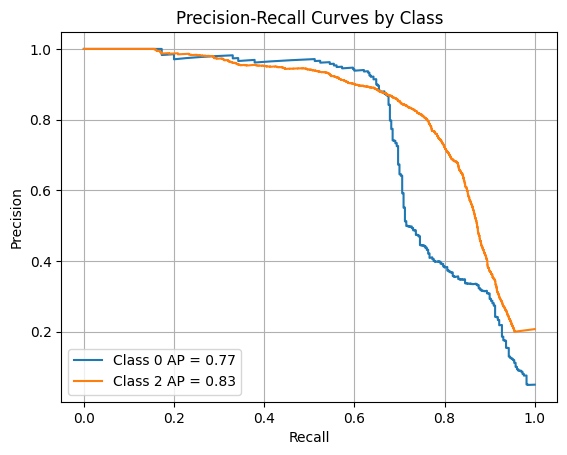

Class 0 AP = 0.769
Class 2 AP = 0.832


In [ ]:
results = evaluate_precision_recall(gt_bboxes, merged_by_frame, iou_thresh=0.5)
for cls, metrics in results.items():
    print(f"Class {cls} AP = {metrics['ap']:.3f}")

Video of Detetction

In [ ]:
import cv2
import os

# SETTINGS
sequence_name = "thun_01_b"  # Directory containing the images
output_path = "fused_detections.mp4"
frame_width = 640  # Change based on your frame size
frame_height = 480
fps = 20  # Match your video FPS
confidence_threshold = 0.5

# Create VideoWriter
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

# Loop through frames in order
for frame_idx in tqdm(sorted(merged_by_frame.keys())):
    frame_path = os.path.join(sequence_name, f"{frame_idx:06d}.png")
    frame = cv2.imread(frame_path)

    if frame is None:
        print(f"⚠️ Frame {frame_idx} not found at {frame_path}")
        continue

    detections = merged_by_frame[frame_idx]

    event_drawn_frame = get_event_frame_rgb(frame_idx,frame,sequence_name,alpha=0.9)

    for det in detections:
        x1, y1, x2, y2, conf, cls = det
        x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
        color = (0, 255, 255)  # Yellow

        if conf > confidence_threshold:
            cv2.rectangle(event_drawn_frame, (x1, y1), (x2, y2), color, 2)
            label = f"Cls {int(cls)} | {conf:.2f}"
            cv2.putText(event_drawn_frame, label, (x1, y1 - 8), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

    out.write(event_drawn_frame)

out.release()
print("✅ Video with fused detections saved to:", output_path)


100%|██████████| 1079/1079 [00:35<00:00, 30.80it/s]

✅ Video with fused detections saved to: fused_detections.mp4


### Tracking vid

Tracking

In [ ]:
from collections import defaultdict
from deep_sort_realtime.deepsort_tracker import DeepSort
import cv2

tracker = DeepSort(
    max_age=3,
    n_init=3,
    nms_max_overlap=0.5,
    max_cosine_distance=0.3,
    nn_budget=100,
    override_track_class=None,
    embedder="mobilenet",
    half=True,
    bgr=True,
    embedder_gpu=True,
    polygon=False,
    today=False  
)

tracked_by_frame = defaultdict(list)

for frame_idx in tqdm(sorted(merged_by_frame.keys())):
    frame_tracks = []  # ✅ Important: reset for each frame

    dets = merged_by_frame[frame_idx]
    input_dets = [([d[0], d[1], d[2] - d[0], d[3] - d[1]], d[4], d[5]) for d in dets]

    frame = cv2.imread(f"thun_01_b/{frame_idx:06d}.png")
    if frame is None:
        print(f"Frame {frame_idx} not found")
        continue

    h, w = frame.shape[:2]
    tracks = tracker.update_tracks(input_dets, frame=frame)

    for track in tracks:
        if not track.is_confirmed():
            continue

        ltrb = track.to_ltrb(orig=True)
        if ltrb is None:
            continue  # skip if no matched detection

        x1, y1, x2, y2 = map(int, ltrb)

        x1 = max(0, min(x1, w - 1))
        y1 = max(0, min(y1, h - 1))
        x2 = max(0, min(x2, w - 1))
        y2 = max(0, min(y2, h - 1))

        cls = track.get_det_class()
        track_id = track.track_id

        frame_tracks.append([x1, y1, x2, y2, track_id, cls])

        #print(f"Frame {frame_idx} — ID {track_id} — BBox ({x1}, {y1}, {x2}, {y2}) — Class {cls}")

    tracked_by_frame[frame_idx] = frame_tracks  # ✅ Now correct



100%|██████████| 1079/1079 [01:03<00:00, 17.10it/s]


Tracking video

In [ ]:
import cv2

# Initialize writer (adjust resolution and fps)
output_path = "tracked_output.mp4"
frame_height, frame_width = 480, 640  # change to your frame size
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, 20.0, (frame_width, frame_height))

# Loop through frames
for frame_idx in tqdm(sorted(merged_by_frame.keys())):
    frame_path = f"thun_01_b/{frame_idx:06d}.png"
    #print(f"Processing frame: {frame_path}")
    frame = cv2.imread(frame_path)

    detections = tracked_by_frame[frame_idx]

    input_dets = [([d[0], d[1], d[2] - d[0], d[3] - d[1]], d[4], d[5]) for d in detections]

    tracks = tracker.update_tracks(input_dets, frame=frame)

    # Draw tracks
    for track in tracks:
        if not track.is_confirmed():
            continue

        ltrb = track.to_ltrb(orig=True)
        if ltrb is None:
            continue  # only draw if there's a matched detection

        x1, y1, x2, y2 = map(int, ltrb)

        track_id = track.track_id
        cls = track.get_det_class()

        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(frame, f'ID {track_id} | Cls {cls}', (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)
        
    out.write(frame)

out.release()
print("✅ Video saved to:", output_path)

  0%|          | 0/1079 [00:00<?, ?it/s]

100%|██████████| 1079/1079 [01:02<00:00, 17.38it/s]

✅ Video saved to: tracked_output.mp4


## Get the data in the correct format for TrackEval

[TrackEval repo](https://github.com/JonathonLuiten/TrackEval?tab=readme-ov-file)

In [ ]:
def change_to_MOT_format(data_by_frame,is_it_gt=False):

    for frame_idx in tqdm(sorted(data_by_frame.keys())):

        detections = data_by_frame[frame_idx]

        event_drawn_frame = get_event_frame_rgb(frame_idx,frame,sequence_name,alpha=0.9)

        for det in detections:
            x1, y1, x2, y2, conf, cls = det